In [187]:
import os

In [188]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [189]:
sales = pd.read_csv("train.csv")
sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


Cleaning: Check for nulls, convert date to daytime, 

In [190]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [191]:
sales = sales.drop(['store','item'],axis = 1)
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [192]:
sales['date'] = pd.to_datetime(sales['date'])
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [193]:
#convert month to data and then sum number of items in each month
sales['date'] = sales['date'].dt.to_period(freq = "M")
monthly_sales = sales.groupby('date').sum().reset_index()

In [194]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [195]:
monthly_sales.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


Visualization

Text(0.5, 1.0, 'monthly_sales')

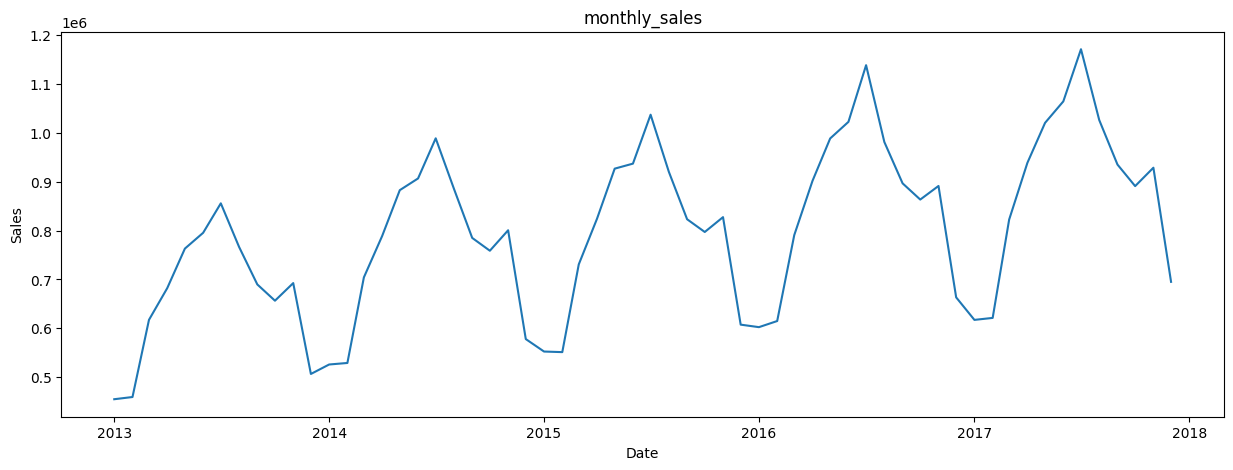

In [196]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("monthly_sales")

In [197]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head()

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0


In [198]:
# plt.figure(figsize=(15,5))
# plt.plot(sales_diff['date'],sales_diff['sales'])
# plt.xlabel("Date")
# plt.ylabel("Sales")
# plt.title("Monthly Customer Sales Difference")
# plt.show()


Dropping off sales and date

In [199]:
supervised_data = monthly_sales.drop(['date','sales'], axis = 1)
# #supervised_data
# #prepare the supervised data: iterate over 0-12 

In [200]:
#sales difference based on store (rows) and for each month (cols)
for i in range (1,13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
    
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


Split the data into train and test

In [201]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape", train_data.shape)
print("Test Data Shape", test_data.shape)
test_data

Train Data Shape (35, 13)
Test Data Shape (12, 13)


,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
35,-46105.0,-228037.0,27811.0,-33194.0,-84663.0,-157224.0,116054.0,33934.0,86780.0,111069.0,175924.0,12518.0,-5133.0
36,4063.0,-46105.0,-228037.0,27811.0,-33194.0,-84663.0,-157224.0,116054.0,33934.0,86780.0,111069.0,175924.0,12518.0
37,201298.0,4063.0,-46105.0,-228037.0,27811.0,-33194.0,-84663.0,-157224.0,116054.0,33934.0,86780.0,111069.0,175924.0
38,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0,-33194.0,-84663.0,-157224.0,116054.0,33934.0,86780.0,111069.0
39,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0,-33194.0,-84663.0,-157224.0,116054.0,33934.0,86780.0
40,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0,-33194.0,-84663.0,-157224.0,116054.0,33934.0
41,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0,-33194.0,-84663.0,-157224.0,116054.0
42,-144990.0,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0,-33194.0,-84663.0,-157224.0
43,-91140.0,-144990.0,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0,-33194.0,-84663.0
44,-44103.0,-91140.0,-144990.0,106769.0,43938.0,81824.0,116195.0,201298.0,4063.0,-46105.0,-228037.0,27811.0,-33194.0


In [202]:

scalar = MinMaxScaler(feature_range= (-1,1))
scalar.fit(train_data)
train_data = scalar.transform(train_data)
test_data = scalar.transform(test_data)


In [203]:
x_train , y_train = train_data[:,1:], train_data[:,0:1]
x_test , y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train Shape", x_train.shape)
print("y_train Shape", y_train.shape)
print("X_test Shape", x_test.shape)
print("y_test Shape", y_test.shape)


X_train Shape (35, 12)
y_train Shape (35,)
X_test Shape (12, 12)
y_test Shape (12,)


In [204]:
#Make prediction datafram tp merge predicted sales prices of all trained alg
sales = monthly_sales['date'][-12:].reset_index(drop = True)
predict_df = pd.DataFrame(sales)

In [205]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


In [206]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_predict = lr_model.predict(x_test)

In [207]:
lr_predict = lr_predict.reshape(-1,1)
#this is a set matrix - contains the input ft of the test data
lr_predict_test_set = np.concatenate([lr_predict, x_test], axis = 1)
lr_predict_test_set = scalar.inverse_transform(lr_predict_test_set)


In [208]:
#we hae created a linear regression prediction and have reshaped it.
#created test set for linear regression prediction model 
#used numpy package to concatonate the prediction model and the xtest 
#used MinMaxScalar to to overwrite to the inverse transformation of the linear progression test set
#we have created a test set matrix: contain the x test (input of of test data)

In [209]:
result_list = []
for index in range(0, len(lr_predict_test_set)):
    result_list.append(lr_predict_test_set[index][0] + act_sales[index])
lr_predict_series = pd.Series(result_list, name= "Linear Prediction")
predict_df = predict_df.merge(lr_predict_series, left_index = True, right_index = True)
print(predict_df)


         date  Linear Prediction
0  2017-01-01       6.479148e+05
1  2017-02-01       6.283374e+05
2  2017-03-01       8.195190e+05
3  2017-04-01       9.436391e+05
4  2017-05-01       1.033653e+06
5  2017-06-01       1.065286e+06
6  2017-07-01       1.201561e+06
7  2017-08-01       1.002123e+06
8  2017-09-01       9.415142e+05
9  2017-10-01       9.080646e+05
10 2017-11-01       9.167461e+05
11 2017-12-01       6.947978e+05


In [210]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae= mean_absolute_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])

print("Linear Regression MSE: ", lr_mse)
print("Linear Regression Mae: ", lr_mae)
print("Linear Regression R2: ", lr_r2)

Linear Regression MSE:  16221.272385416883
Linear Regression Mae:  12433.184266490754
Linear Regression R2:  0.9906152516380969


visualisation of the prediction against the actual sales

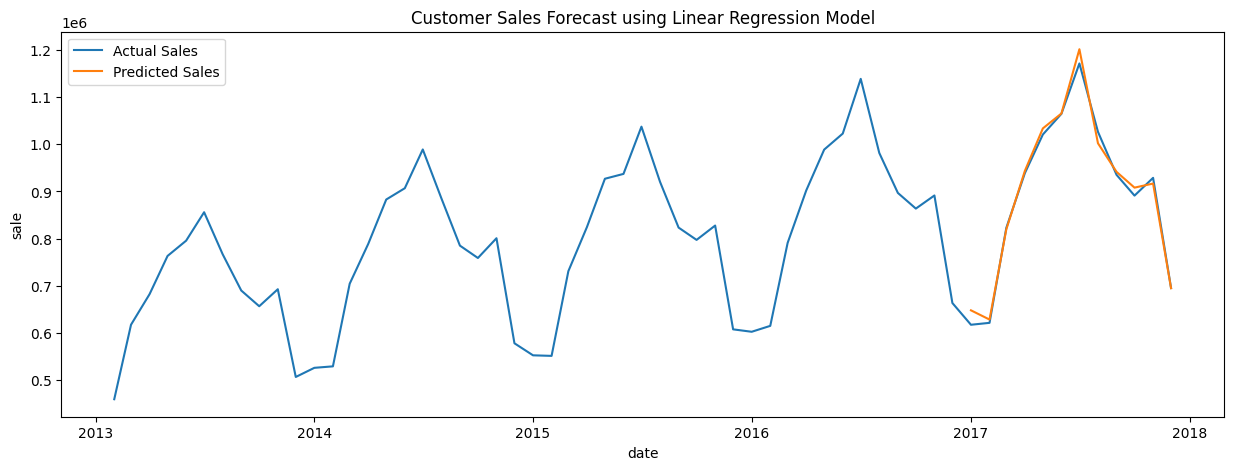

In [213]:
plt.figure(figsize=(15,5))
#actual
plt.plot(monthly_sales['date'],monthly_sales['sales'])
#predict
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title("Customer Sales Forecast using Linear Regression Model")
plt.xlabel("date")
plt.ylabel("sale")
plt.legend(['Actual Sales','Predicted Sales'])
plt.show()